In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def linear_model(x, m, c):
    return m*x + c

### Generate data with Gaussian noise

\begin{align}
y = f(x) + n
\end{align}

Fetch some $\{y_i, x_i\}$. $n$ is a Gaussian.

In [3]:
injection_parameters = dict(m=0.8, c=2)

In [4]:
num_points = 100
x = np.linspace(-4, 4, num_points)

In [5]:
sigma = 0.6

In [6]:
data = linear_model(x, **injection_parameters) + np.random.normal(0, sigma, x.size)

Text(0, 0.5, 'y')

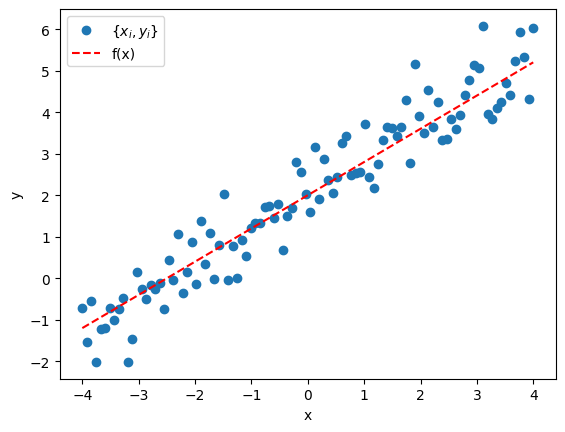

In [7]:
fig, ax = plt.subplots()
ax.plot(x, data, 'o', label='$\\{x_i, y_i\\}$')
ax.plot(x, linear_model(x, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

In [8]:
import bilby
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform, DeltaFunction

In [9]:
priors = dict()

priors['m'] = Uniform(-3, 3, name='m', latex_label='m')
priors['c'] = Uniform(-3, 3, name='c', latex_label='c')

In [10]:
log_l = GaussianLikelihood(x, data, linear_model, sigma=sigma)

In [11]:
result = bilby.run_sampler(
    likelihood=log_l, priors=priors, sampler='dynesty',
    nlive=300, npool=4, save=False, clean=True,
    injection_parameters=injection_parameters,
    outdir='./linear_regression',
    label='linear_regression'
)

16:39 bilby INFO    : Running for label 'linear_regression', output will be saved to './linear_regression'
16:39 bilby INFO    : Analysis priors:
16:39 bilby INFO    : m=Uniform(minimum=-3, maximum=3, name='m', latex_label='m', unit=None, boundary=None)
16:39 bilby INFO    : c=Uniform(minimum=-3, maximum=3, name='c', latex_label='c', unit=None, boundary=None)
16:39 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
16:39 bilby INFO    : Analysis likelihood noise evidence: nan
16:39 bilby INFO    : Single likelihood evaluation took 1.997e-05 s
16:39 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 300, 'bound': 'multi', 'sample': 'rwalk', 'periodic': None, 'reflective': None, 'update_interval': None, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'gradient': None, 'grad_args':

1it [00:00, ?it/s]

16:39 bilby INFO    : Written checkpoint file ./linear_regression/linear_regression_resume.pickle
16:39 bilby INFO    : Starting to close worker pool.
16:39 bilby INFO    : Finished closing worker pool.


16:39 bilby INFO    : Sampling time: 0:00:26.392754
16:39 bilby INFO    : Summary of results:
nsamples: 3448
ln_noise_evidence:    nan
ln_evidence: -96.771 +/-  0.189
ln_bayes_factor:    nan +/-  0.189



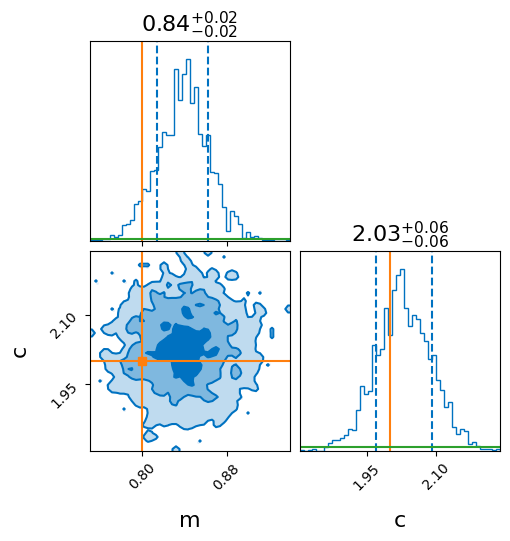

In [12]:
result.plot_corner(priors=True, quantiles=(0.16, 0.84))

In [13]:
print("Expected width of m = {:.2f}".format(sigma/np.sqrt(np.sum((x)**2))))

Expected width of m = 0.03


In [14]:
print("Expected width of c = {:.2f}".format(sigma * np.sqrt(1/num_points)))

Expected width of c = 0.06


# Same problem by training a normalizing flow

In [15]:
from IPython.display import clear_output
from time import sleep

def live_plot_samples(samples, truth):
    clear_output(wait=True)
    sleep(1)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.16, 0.5, 0.84],
        show_titles=True, labels=["m", "c"],
        truth=truth
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")


def live_plot_bilby_result(result, **kwargs):
    clear_output(wait=True)
    sleep(1)
    result.plot_corner(priors=True)

In [16]:
def get_data(m=None, c=None, num_points=1):
    """Sample m, c and return a batch of data with noise"""
    m = priors['m'].sample() if m is None else m
    c = priors['c'].sample() if c is None else c
    #x = 8 * (np.random.uniform(size=num_points) - 0.5)
    x = np.linspace(-4, 4, num_points)
    y = m*x + c
    y += sigma*np.random.normal(size=x.size)

    return x, y, m, c

# Generate simulations

In [17]:
from torch.utils.data import Dataset, DataLoader

In [18]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

In [19]:
num_simulations = 20000
theta_vals = []
data_vals = []
for ii in range(num_simulations):
    x_val, y_val, m_val, c_val = get_data(num_points=100)
    data_vals.append(y_val)
    theta_vals.append([m_val, c_val])

In [20]:
theta_vals = torch.from_numpy(np.array(theta_vals)).to(torch.float32)
data_vals = torch.from_numpy(np.array(data_vals)).to(torch.float32)

In [21]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return theta_vals[idx], data_vals[idx]

In [22]:
dataset = DataGenerator()

In [23]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [24]:
train_data_loader = DataLoader(
    train_data, batch_size=40,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=40,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [25]:
for theta, data in train_data_loader:
    break

In [26]:
theta.shape, data.shape

(torch.Size([40, 2]), torch.Size([40, 100]))

# MADE with std normal

In [5]:
import torch
import torch.distributions as dist

In [6]:
from pyro.nn import ConditionalAutoRegressiveNN
from pyro.distributions import ConditionalTransformedDistribution
from pyro.distributions.transforms import ConditionalAffineAutoregressive

In [7]:
input_dim = 2
context_dim = 100#num_points
hidden_dims = [20*input_dim, 20*input_dim]

base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
hypernet = ConditionalAutoRegressiveNN(input_dim, context_dim, hidden_dims)

transform = ConditionalAffineAutoregressive(hypernet)

In [9]:
flow = ConditionalTransformedDistribution(base_dist, [transform, transform])

In [31]:
optimizer = optim.Adam(transform.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train/Validate

In [32]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        theta, data = val
        
        optimizer.zero_grad()
        loss = -flow.condition(data).log_prob(theta).mean()
        loss.backward()
        optimizer.step()
        # Gather data and report
        running_loss += loss.item()
        if idx % 100 == 0:
            last_loss = running_loss / 100 # avg loss per batch after 1000 batches
            #print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss


def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        theta_val, data_val = val

        loss = -flow.condition(data).log_prob(theta).mean()
        running_loss += loss.item()

        if idx % 50 == 0:
            last_loss = running_loss / 50
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Loss/val', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [33]:
writer = SummaryWriter("linear_regression_using_pyro", comment="With LR=1e-3", flush_secs=5)
epoch_number = 0

In [34]:
from tqdm import tqdm

In [35]:
EPOCHS = 100

for epoch in tqdm(range(EPOCHS), desc='Train loop', leave=False):
    #print('EPOCH {}:'.format(epoch_number + 1))
    # Gradient tracking
    transform.train(True)
    avg_train_loss = train_one_epoch(epoch_number, writer)
    
    # no gradient tracking, for validation
    transform.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer)
    
    #print(f"Train/Val Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")
    epoch_number += 1
    scheduler.step()

In [36]:
print(f"Train/Val Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

Train/Val Loss after epoch: -3.6719/-3.5565


# Check on test data

In [37]:
import pandas as pd
import corner

def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys(injection_parameters)
    injections['m'] = float(truth.numpy()[0])
    injections['c'] = float(truth.numpy()[1])

    posterior = dict.fromkeys(injection_parameters)
    samples_numpy = samples.numpy()
    posterior['m'] = samples_numpy.T[0].flatten()
    posterior['c'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)
    
    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

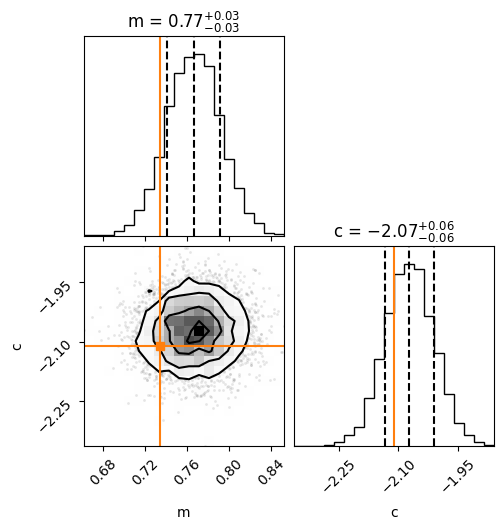

In [38]:
for idx, (theta_test, data_test) in enumerate(test_data):
    if idx == 20: break 
    with torch.no_grad():
        samples = flow.condition(data_test).sample([5000])
    live_plot_samples(samples, theta_test)
    plt.show()

# PP plot

In [39]:
%%time
results = []
for idx, (theta_test, data_test) in enumerate(test_data):
    with torch.no_grad():
        samples = flow.condition(data_test).sample([5000])
    results.append(
        cast_as_bilby_result(samples, theta_test))

CPU times: user 24.2 s, sys: 91.6 ms, total: 24.3 s
Wall time: 1.8 s


16:42 bilby INFO    : Key: KS-test p-value
16:42 bilby INFO    : m: 0.09119460713020111
16:42 bilby INFO    : c: 0.22836914659824514
16:42 bilby INFO    : Combined p-value: 0.10145509826953367


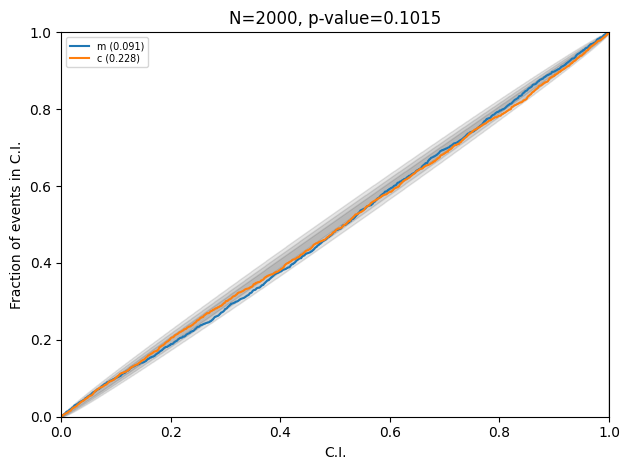

In [40]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilby.result.make_pp_plot(results, save=False, keys=['m', 'c'])